# Name: Harsh #
# Date: 01/26/2022 #

## Simpl interview case study problem 1 ##

## SQL quesries. Syntax used is for BigSQL (google big SQL). Semi colons are not required at the end of the query in BigSQL and hence, I am not using them here. ##

### Assuming tableA is the name of the table used in every query ###

### Please do not execute the SQL queries to maintain their formatiing

#### Question 1 part a ###

#### Query to find the first merchant a user transacts on ##

#### assumption: only one transaction is done per days as otherwise we would need datetime to check which 
#### was the first merchant ##

SELECT
    sb1.user_id,
    sn1.ma AS first_merchant_transacted_on
FROM (
SELECT
    ta.user_id,
    ta.merchant_name as ma,
    ta.transaction_date as td,
    ROW_NUMBER() OVER(PARTITION BY ta.user_id ORDER BY ta.trasaction_date) AS rank
FROM tableA ta
) sb1
WHERE sb1.rank = 1





#### Question 1 part b ###

#### Extract count of users who transacted for the first time on a Monday for each merchant ##

#### assumption: only one transaction is done per days as otherwise we would need datetime to check which 
#### was the first merchant ##

#### in bigquery day of the week syntax, 2 corresponds to monday ####

SELECT
    sb1.merchant_name,
    COUNT(DISTINCT sb1.user_id) AS users,
FROM (
SELECT
    ta.user_id,
    ta.merchant_name as ma,
    EXTRACT(DAYOFWEEK FROM ta.transaction_date) as dow
    ROW_NUMBER() OVER(PARTITION BY ta.merchant_name, ta.user_id ORDER BY ta.trasaction_date) AS rank
FROM tableA ta
) sb1
WHERE sb1.rank = 1 AND sb1.dow = 2
GROUP BY sb1.merchant_name

#### Question 2 ###

#### Write a query to extract alternate rows ordered by date for each user ####
#### assumption: only one transaction is done per days as otherwise we would need datetime ####

###


SELECT
    sb1.* EXCEPT(rank) 
FROM (
SELECT
    ta.user_id,
    ta.merchant_name as ma,
    ta.transaction_date,
    ta.transaction_id,
    ta.amount
    ROW_NUMBER() OVER(PARTITION BY ta.user_id ORDER BY ta.trasaction_date) AS rank
FROM tableA ta
) sb1
WHERE i%2 == 1

#### Question 3 part A ###

#### Write a query to extract top 25% of users based on amount spent for each month ####

SELECT
    sb2.* EXCEPT(perc_75)
FROM (
SELECT
    sb3.MONTH,
    sb3.user_id
    sb3.monthly_sum,
    PERCENTILE_CONT(sb3.monthly_sum, 0.75) OVER (PARTITION BY sb3.MONTH) AS perc_75
FROM (
  SELECT
      EXTRACT(MONTH FROM ttaa.transaction_date) AS MONTH,
      ttaa.user_id,
      SUM(ttaa.amount) AS monthly_sum
  FROM tableA ttaa
  GROUP BY 1, 2
) sb3
) sb2
WHERE sb2.monthly_sum > sb2.perc_75





#### Question 3 part B ###

#### Write a query to extract top 25% of users based on Transaction count for each month ####

SELECT
    sb2.* EXCEPT(perc_75)
FROM (
SELECT
    sb3.MONTH,
    sb3.user_id
    sb3.monthly_transactions,
    PERCENTILE_CONT(sb3.monthly_transactions, 0.75) OVER (PARTITION BY sb3.MONTH) AS perc_75
FROM (
  SELECT
      EXTRACT(MONTH FROM ttaa.transaction_date) AS MONTH,
      ttaa.user_id,
      COUNT(*) AS monthly_transactions
  FROM tableA ttaa
  GROUP BY 1, 2
) sb3
) sb2
WHERE sb2.monthly_transactions > sb2.perc_75


#### Question 3 part C ###

#### Write a query to extract top 25% of users based on Transaction count for each month ####

SELECT
    sb2.* EXCEPT(perc_75)
FROM (
SELECT
    sb3.user_id
    sb3.monthly_sum,
    PERCENTILE_CONT(sb3.monthly_sum, 0.75) AS perc_75
FROM (
  SELECT
      ttaa.user_id,
      SUM(ttaa.amount) AS monthly_sum
  FROM tableA ttaa
  GROUP BY 1
) sb3
) sb2
WHERE sb2.monthly_sum > sb2.perc_75

#### Question 3 part D ###

#### Write a query to extract top 25% of users based on Total transaction count till date ####

SELECT
    sb2.* EXCEPT(perc_75)
FROM (
SELECT
    sb3.user_id
    sb3.monthly_sum,
    PERCENTILE_CONT(sb3.monthly_transactions, 0.75) AS perc_75
FROM (
  SELECT
      ttaa.user_id,
      SUM(*) AS monthly_transactions
  FROM tableA ttaa
  GROUP BY 1
) sb3
) sb2
WHERE sb2.monthly_transactions > sb2.perc_75

#### Question 4 ###
#### Write a query to calculate time difference (in days) between current and previous order of
#### each customer for every row and the avg time difference between two orders for every customer.


WITH data AS (
SELECT
    ta.user_id,
    ta.merchant_name,
    ta.transaction_date,
    ta.amount,
    LEAD(ta.transaction_date) (PARTITION BY ta.user_id ORDER BY ta.transaction_date) AS lead_date,
    LAG(ta.transaction_date) (PARTITION BY ta.user_id ORDER BY ta.transaction_date) AS lag_date,
FROM tableA ta
),
lag_lead AS (
SELECT
    sb1.user_idm
    sb1.merchant_name,
    sb1.transaction_date,
    sb1.amount,
    DATE_DIFF(sb1.transaction_date, lag_date, DAY) AS time_between_current_previous,
    DATE_DIFF(sb1.lead_date, sb1.transaction_date, DAY) AS time_between_two_orders
),
avg_data AS (
SELECT
    ll.user_id,
    AVG(ll.time_between_two_orders) AS avg_time_between_orders
FROM lag_lead ll
GROUP BY 1
)
SELECT
    lls.user_idm
    lls.merchant_name,
    lls.transaction_date,
    lls.amount,
    lls.time_between_current_previous,
    ad.avg_time_between_orders
FROM lag_lead lls
INNER JOIN avg_data ad
ON lls.user_id = ad.user_id


#### Question 5 ####

#### Write a query to get the count of users who transact in 3 continuous months. ####

SELECT
    COUNT(DISTINCT sb2.user_id) AS number_of_users
FROM (
SELECT
    sb1.user_id,
    sb1.MONTH,
    LEAD(sb1.MONTH) OVER (PARTITION BY sb1.user_id) AS lead_month,
    LAG(sb1.MONTH) OVER (PARTITION BY sb1.user_id) AS lag_month
FROM (
SELECT
    EXTRACT(MONTH FROM ta.transaction_date) AS MONTH,
    ta.user_id,
    COUNT(*)
FROM tableA ta
GROUP BY 1, 2
) sb1
) sb2
WHERE sb2.MONTH = sb2.lead_month - 1 AND sb2.month = sb2.lag_month + 1


## Simpl interview case study problem 2 ##
## predicting who to approve and what should be the limit ##

### Execute the code from here ###

In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import sklearn
from sklearn.preprocessing import PolynomialFeatures
import missingno as mi
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.anova import anova_lm
import random
from statsmodels.formula.api import ols
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import statistics
from sklearn.metrics import confusion_matrix
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
from datetime import date

import pandas as pd
import numpy as np

import holoviews as hv
import plotly.graph_objects as go
import plotly.express as pex

import re

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, KFold

import xgboost as xgb

In [593]:
#### reading the data set ####

data = pd.read_csv('case_study_data.csv')

data.head()


,user_id,gender,date_of_birth,workclass,education_level,education_num,marital_status,occupation,relationship,capital_gain,...,hours_per_week,approved,address,email,inquiry_purpose_code,institute_type,account_type,asset_class_cd,asset_code,portfolio_type
0,307c73a3-0c67-43b5-b0d1,Female,03/01/87,Private,11th,7,Never-married,Sales,Unmarried,0,...,17,0,"45424 Norris Common Apt. 390\nNorth Mike, AR 8...",vasquezleah@yahoo.com,7.0,PVT,5,NaN,1.0,R
1,519481f1-604d-48b6-aa47,Male,07/01/70,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Craft-repair,Husband,0,...,48,0,"5022 Rebecca Haven Apt. 258\nThompsonfurt, CT ...",johnsontrevor@hotmail.com,13.0,NBF,5,NaN,1.0,R
2,f66fe2c6-53e3-46ce-8321,Male,06/01/73,Private,HS-grad,9,Divorced,Sales,Not-in-family,0,...,50,0,"8780 Brown Loaf Apt. 099\nNorth David, NJ 56510",morganemily@gmail.com,13.0,NBF,5,NaN,1.0,R
3,91360ed7-72d1-4f6e-b492,Female,30/12/01,Private,11th,7,Never-married,Sales,Own-child,0,...,15,0,721 Jackson Extensions Suite 995\nNew Taraside...,agarcia@hotmail.com,13.0,NBF,5,NaN,1.0,R
4,0e1977f3-3bef-4283-8d0a,Male,03/01/86,Private,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,0,...,50,0,"935 Burch Divide\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,13.0,PVT,47,S,1.0,I


In [594]:
### columns in the dataset ###

data.columns

Index(['user_id', 'gender', 'date_of_birth', 'workclass', 'education_level',
       'education_num', 'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss', 'hours_per_week', 'approved', 'address',
       'email', 'inquiry_purpose_code', 'institute_type', 'account_type',
       'asset_class_cd', 'asset_code', 'portfolio_type'],
      dtype='object')

In [595]:
### number of columns in the dataset ###

len(list(data.columns))

21

AxesSubplot(0.125,0.125;0.775x0.755)


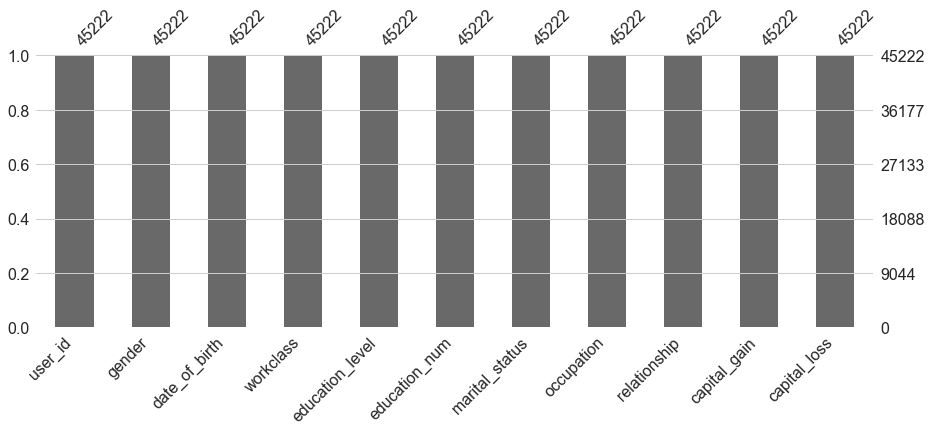

In [596]:
#### checking null values in any of the columns ####

print(mi.bar(data.iloc[:,0:11], figsize = (15,5)))

AxesSubplot(0.125,0.125;0.775x0.755)


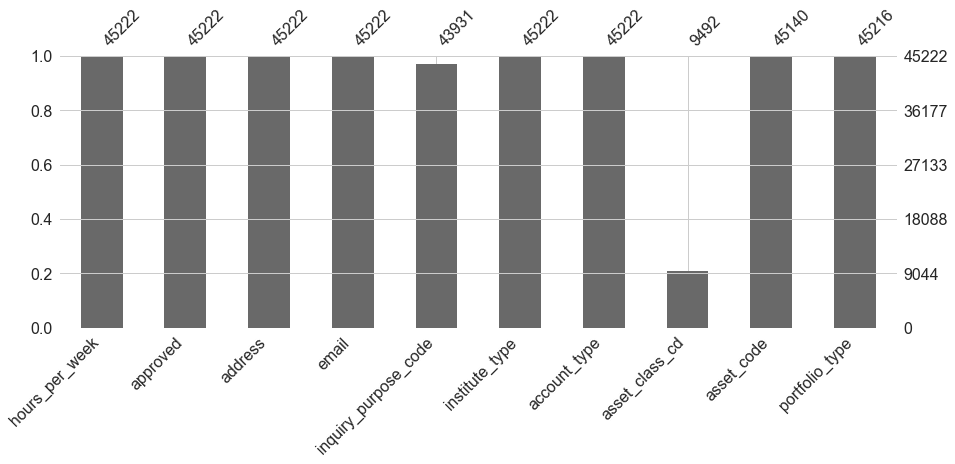

In [597]:
## checking null values in rest of the columns ##

print(mi.bar(data.iloc[:,11:], figsize = (15,5)))

One of the columns (asset_class_cd) as only 20% non null values. Since, this number is way below the rule of thumb of 40%, we will not attempt to impute the values. If the number would have been closer to 40%, we would have created a predictive model to first predict the values of asset_class_cd and then use the predicted values to run the overall model. inquiry_purpose_code has about 3% null values. asset_code alos has some null values. We will check of they are distributed completely at random and if yes, we can remove them directly as it won't lead to reduction of large number of data points.

In [598]:
### removing the column ###

mod_data = data.drop(["asset_class_cd"], axis = 1)
mod_data.head(10)

,user_id,gender,date_of_birth,workclass,education_level,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,approved,address,email,inquiry_purpose_code,institute_type,account_type,asset_code,portfolio_type
0,307c73a3-0c67-43b5-b0d1,Female,03/01/87,Private,11th,7,Never-married,Sales,Unmarried,0,0,17,0,"45424 Norris Common Apt. 390\nNorth Mike, AR 8...",vasquezleah@yahoo.com,7.0,PVT,5,1.0,R
1,519481f1-604d-48b6-aa47,Male,07/01/70,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Craft-repair,Husband,0,0,48,0,"5022 Rebecca Haven Apt. 258\nThompsonfurt, CT ...",johnsontrevor@hotmail.com,13.0,NBF,5,1.0,R
2,f66fe2c6-53e3-46ce-8321,Male,06/01/73,Private,HS-grad,9,Divorced,Sales,Not-in-family,0,0,50,0,"8780 Brown Loaf Apt. 099\nNorth David, NJ 56510",morganemily@gmail.com,13.0,NBF,5,1.0,R
3,91360ed7-72d1-4f6e-b492,Female,30/12/01,Private,11th,7,Never-married,Sales,Own-child,0,0,15,0,721 Jackson Extensions Suite 995\nNew Taraside...,agarcia@hotmail.com,13.0,NBF,5,1.0,R
4,0e1977f3-3bef-4283-8d0a,Male,03/01/86,Private,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,0,0,50,0,"935 Burch Divide\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,13.0,PVT,47,1.0,I
5,3c8fbbaf-cd9d-4e17-8cd4,Female,11/01/56,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,0,0,8,0,"93533 Moore Greens\nWest Alicia, NC 34941",frostvictor@west-barron.biz,99.0,NBF,5,1.0,R
6,27256e97-6bae-4ce6-9b80,Female,30/12/01,Private,HS-grad,9,Never-married,Sales,Own-child,0,0,24,0,90598 Richardson Mountains Apt. 192\nJohnsonfu...,calvin66@hotmail.com,14.0,HFC,5,1.0,R
7,745b9022-fe0e-4d8e-8056,Female,31/12/96,Private,Some-college,10,Never-married,Farming-fishing,Not-in-family,0,0,50,0,"28328 Bradley Views Suite 367\nSmithport, AK 5...",bwalker@yahoo.com,13.0,PVT,5,1.0,R
8,9b56df25-024a-47fe-b895,Male,05/01/77,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,0,0,45,0,47303 Sarah Freeway Suite 045\nLake Mariaborou...,rperkins@yahoo.com,10.0,PVT,5,1.0,R
9,3257eeda-137c-4d8c-a295,Female,09/01/63,State-gov,12th,8,Divorced,Other-service,Unmarried,0,0,40,0,"7536 Davis Street Suite 960\nLuisfort, VA 25279",emilymiller@martinez.com,7.0,PVT,5,1.0,R


'inquiry_purpose_code' in the the data also has some null values but it only accounts for 3% of the overall data
and hence, we can remove them but we first have to confirm that the data is missing completely at random 

In [599]:
### visualizing the missing data in a inquiry_purpose_code and asset code ###

<AxesSubplot:>

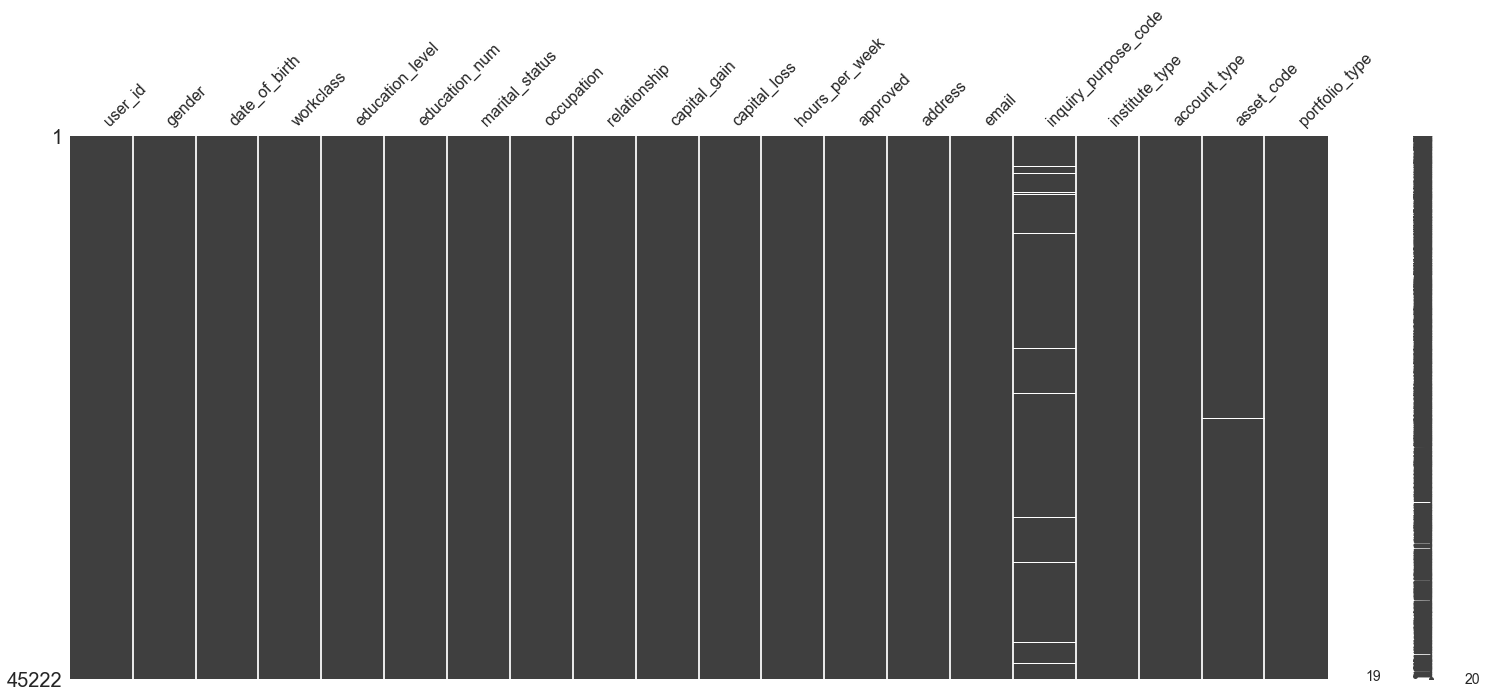

In [600]:
mi.matrix(mod_data)

There is no clear pattern in the missing data and hecen we can directly remove null values. 

In [601]:
mod_data = mod_data[~pd.isna(mod_data['inquiry_purpose_code'])]
mod_data = mod_data[~pd.isna(mod_data['asset_code'])]

<AxesSubplot:>

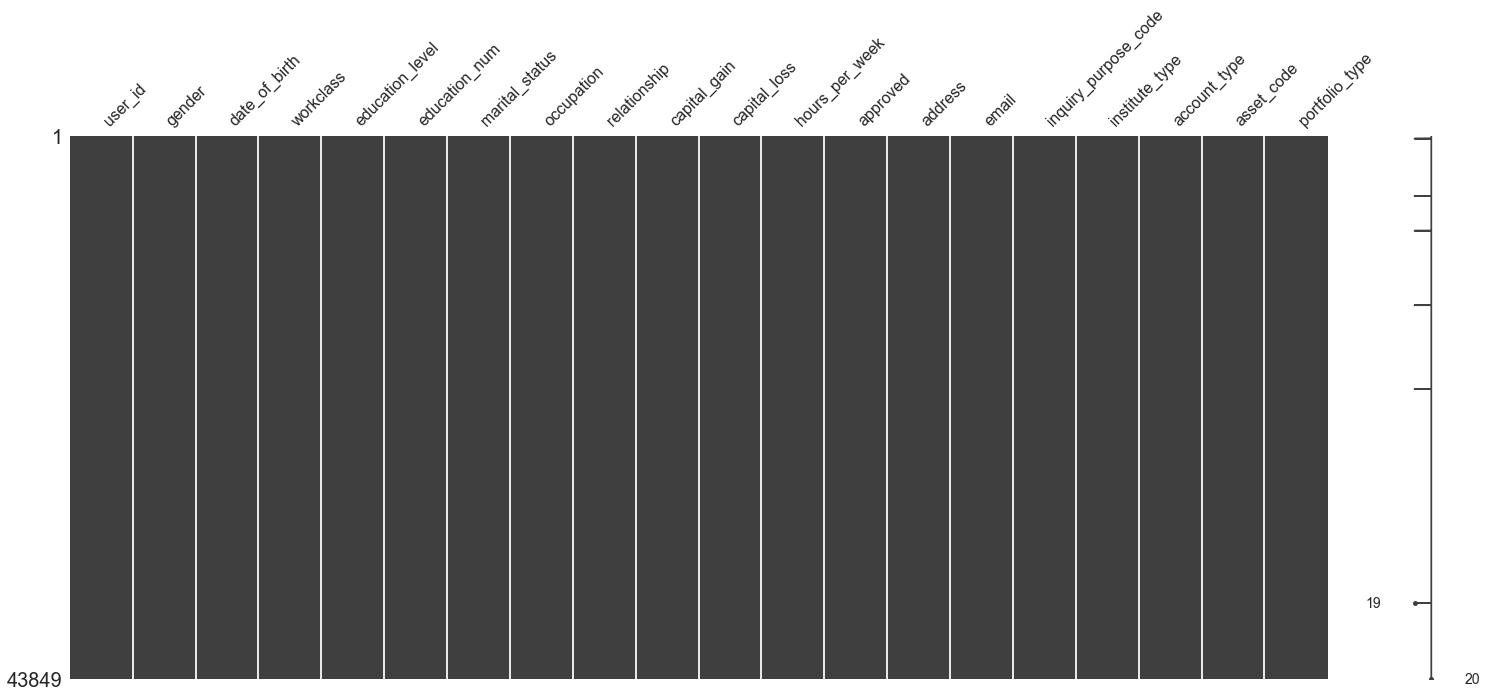

In [602]:
### checking the null values again ###

mi.matrix(mod_data)

### exploratory data analysis ###

We have the address data but it's not usable in this current form. We can take zipcode out of it and try to use that in our analysis. Geographical location is can create biases in the data or may actually give sign whether the particular user will default or not. 

In [603]:
mod_data['zipcode'] = list(("").join(list(i)[-5:]) for i in list(mod_data['address']))

We can extract the domain name from the email address. 
That might be one of the factors which can help us in predicting whether to approve or reject a user.

In [604]:
## if the domain name is not one of gmail, yahoo or hotmail, it's marked as others ##

mod_data['domain'] = list(re.search(r"(.*)@(.*)\.", i).group(2) for i in list(mod_data['email']))
mod_data['domain'] = list(i if i in ["gmail", "yahoo", "hotmail"] else "other" for i in list(mod_data['domain']))

We have the date of birth. From the date of birth, we can calculate the current age of the user. 

In [605]:
### converting the dob column in required column ###

mod_data['date_of_birth'] = list(pd.to_datetime(i, format = "%d/%m/%y") for i in list(mod_data['date_of_birth']))
current_date = date(2022, 1, 25)

mod_data['age'] = list(((current_date - datetime.date(i)).days)/365 for i in list(mod_data['date_of_birth']))

### in some case, years like 1956 are being changed to 2056 ###
### taking care of that issue ###
mod_data['age'] = list(i if i >= 0 else i+100 for i in list(mod_data['age']))

In [606]:
## description of the data frame ##

mod_data.describe()

,education_num,capital_gain,capital_loss,hours_per_week,approved,inquiry_purpose_code,account_type,asset_code,age
count,43849.000000,43849.000000,43849.000000,43849.000000,43849.000000,43849.000000,43849.000000,43849.000000,43849.000000
mean,10.120094,1119.200666,89.215946,40.939907,0.249857,28.933613,80.720974,1.063377,40.640224
std,2.555735,7609.215785,406.407564,12.015284,0.432935,35.390968,144.687443,0.705345,13.195590
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,5.000000,1.000000,19.084932
25%,9.000000,0.000000,0.000000,40.000000,0.000000,13.000000,5.000000,1.000000,30.084932
50%,10.000000,0.000000,0.000000,40.000000,0.000000,13.000000,5.000000,1.000000,39.084932
75%,13.000000,0.000000,0.000000,45.000000,0.000000,16.000000,173.000000,1.000000,49.084932
max,16.000000,99999.000000,4356.000000,99.000000,1.000000,99.000000,999.000000,19.000000,92.016438


In [607]:
## we will now look at how diffeent columns are distributes ###

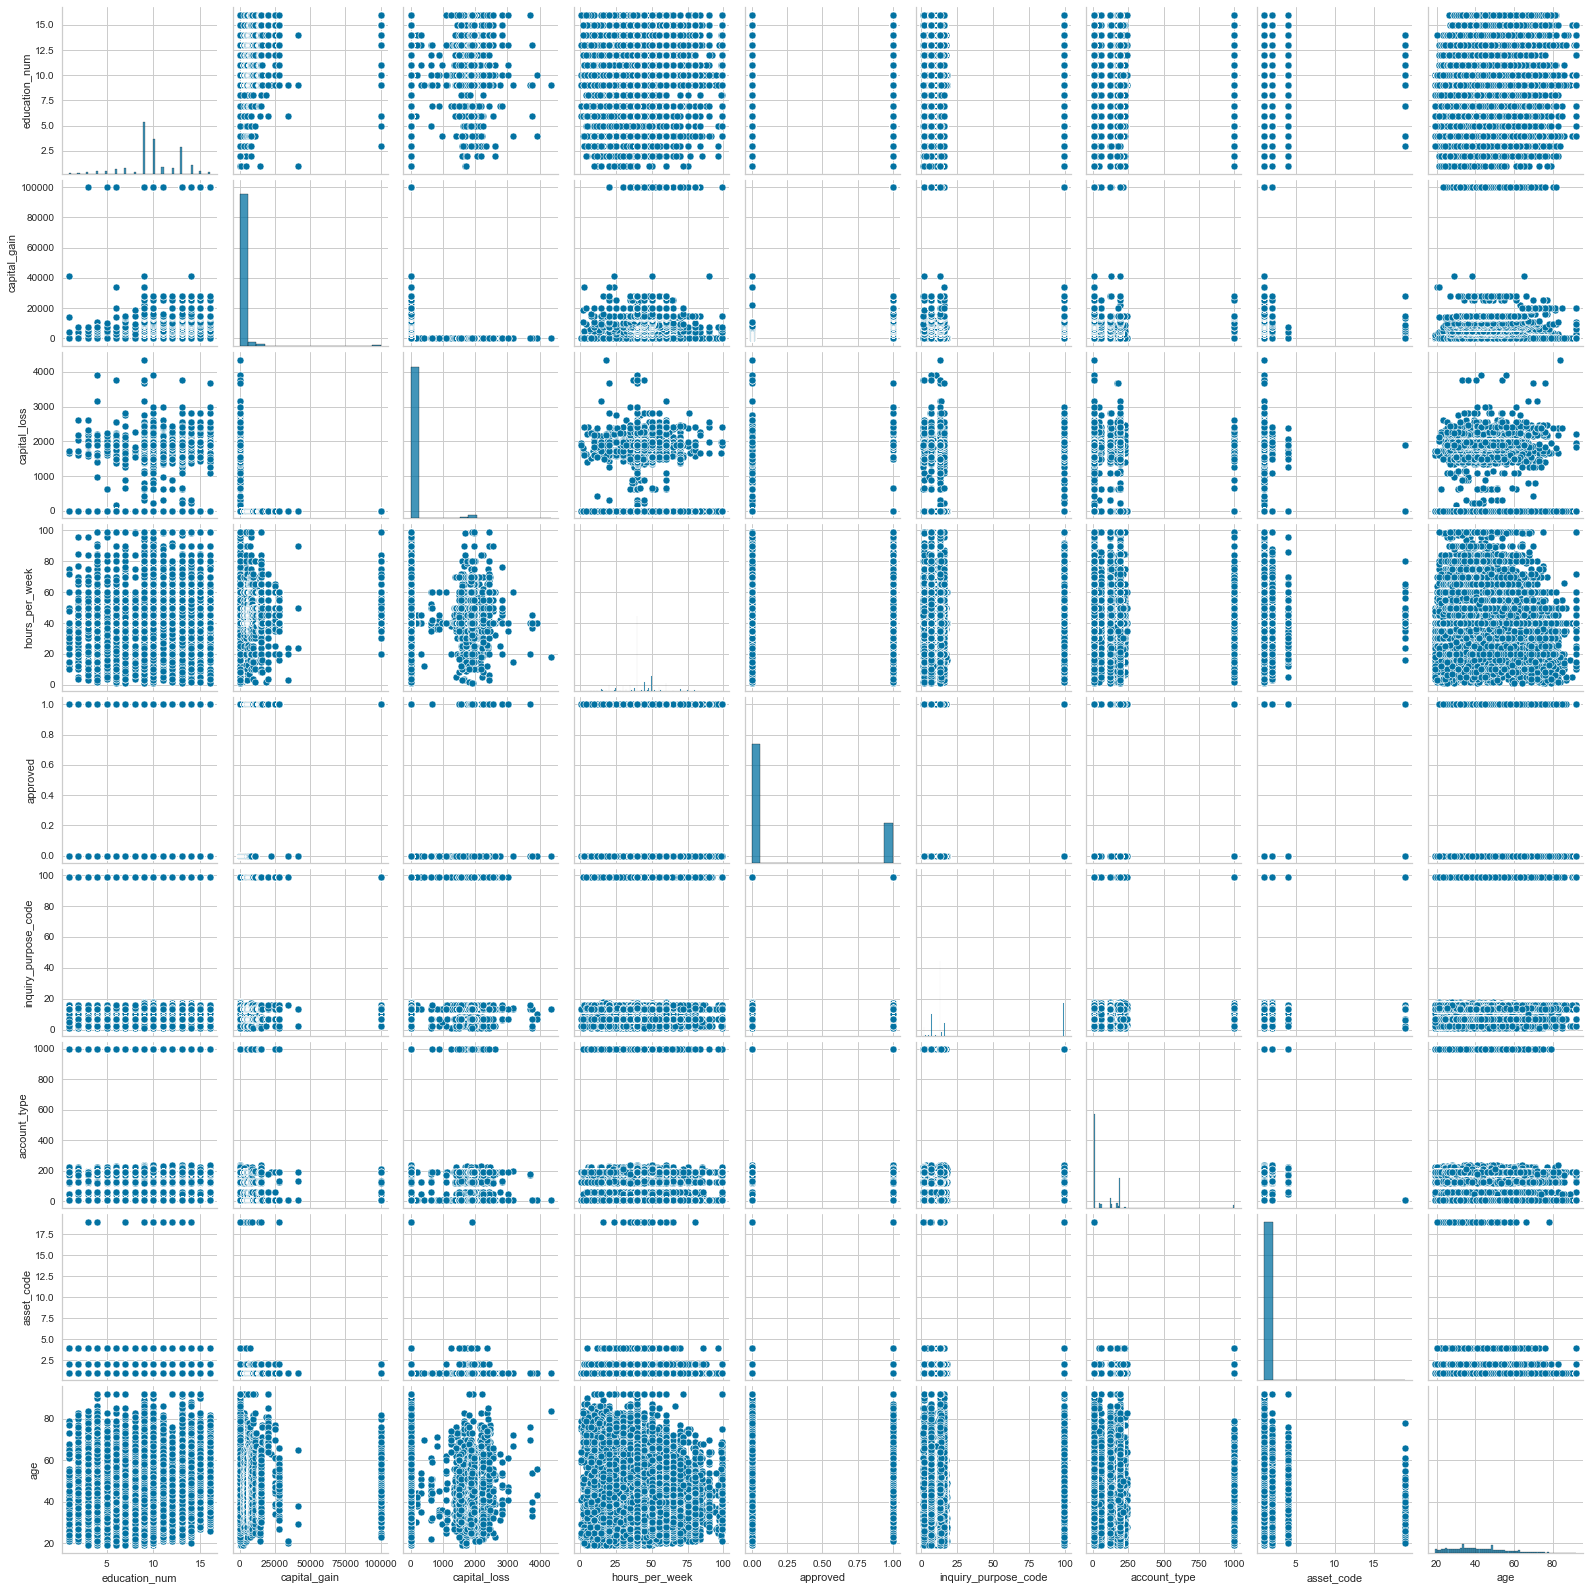

In [608]:
sns.pairplot(mod_data)

In [609]:
uni = mod_data.drop_duplicates(['user_id'], keep = "first")

len(list(uni.index)) == len(list(mod_data.index))

True

In [610]:
mod_data.corr()

## there is no clear high colinearity between the variables ##

,education_num,capital_gain,capital_loss,hours_per_week,approved,inquiry_purpose_code,account_type,asset_code,age
education_num,1.000000,0.127238,0.083101,0.146386,0.333068,0.028970,-0.032596,-0.003463,0.038476
capital_gain,0.127238,1.000000,-0.032289,0.084251,0.220460,-0.002066,-0.048366,-0.001447,0.079905
capital_loss,0.083101,-0.032289,1.000000,0.055173,0.149172,0.006645,-0.002758,-0.002735,0.060364
hours_per_week,0.146386,0.084251,0.055173,1.000000,0.227841,0.013571,-0.022670,0.005452,0.102559
approved,0.333068,0.220460,0.149172,0.227841,1.000000,0.085107,-0.058199,0.000795,0.238074
inquiry_purpose_code,0.028970,-0.002066,0.006645,0.013571,0.085107,1.000000,-0.063399,0.006291,0.026184
account_type,-0.032596,-0.048366,-0.002758,-0.022670,-0.058199,-0.063399,1.000000,0.008458,-0.020554
asset_code,-0.003463,-0.001447,-0.002735,0.005452,0.000795,0.006291,0.008458,1.000000,-0.004445
age,0.038476,0.079905,0.060364,0.102559,0.238074,0.026184,-0.020554,-0.004445,1.000000


since the above condition is true, we know that we have data for unique user ids and hence, 
assume that each row correspond to a unique user.

we can't see clear pattern for particular variable transformations from the above chart.

<AxesSubplot:xlabel='age', ylabel='Count'>

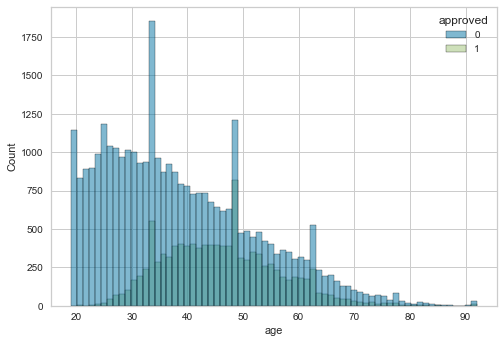

In [611]:
sns.histplot(x = "age", hue = "approved", data = mod_data)

It is clear from the above graph that users who are older are more likely to get approved. 

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


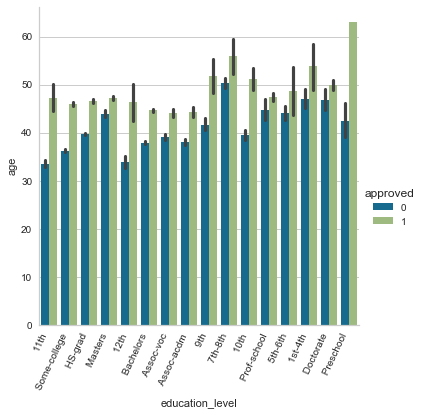

In [612]:
ax = sns.factorplot(x='education_level', y='age', hue='approved', data=mod_data, kind='bar')
ax.set_xticklabels(rotation=65, horizontalalignment='right')

From the above graph too, it is clear that in each education level, 
users who get approved are on average has a higher age.

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


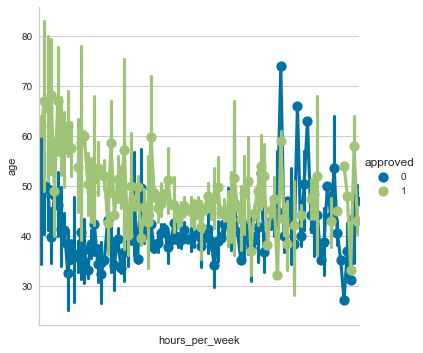

In [613]:
ax = sns.factorplot(x='hours_per_week', y='age', hue='approved', data=mod_data, kind='point')
ax.set_xticklabels(label = None, rotation=65, horizontalalignment='right')
ax.set(xticklabels=[])

Again, there is a clear pattern that age plays a major role in deciding who to approve and whom to decline. 

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


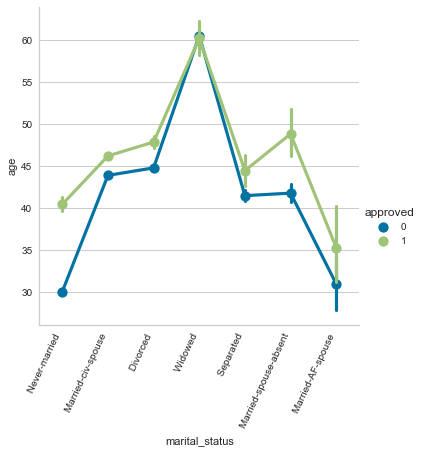

In [615]:
ax = sns.factorplot(x='marital_status', y='age', hue='approved', data=mod_data, kind='point')
ax.set_xticklabels(label = None, rotation=65, horizontalalignment='right')


Both approved and disapproved rates are higher in people who have atleast been married once (regardless of their 
current status). This may point towards human biases that might come into play while making such decisions. 

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


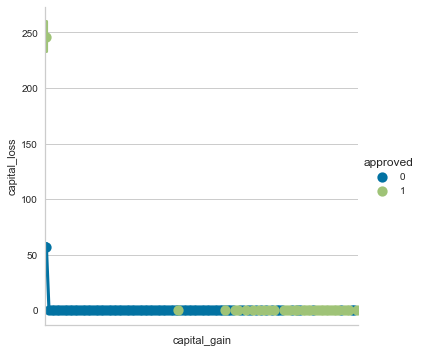

In [540]:
ax = sns.factorplot(x='capital_gain', y='capital_loss', hue='approved', data=mod_data, kind='point')
ax.set_xticklabels(label = None, rotation=65, horizontalalignment='right')
ax.set(xticklabels=[])

<AxesSubplot:xlabel='age'>

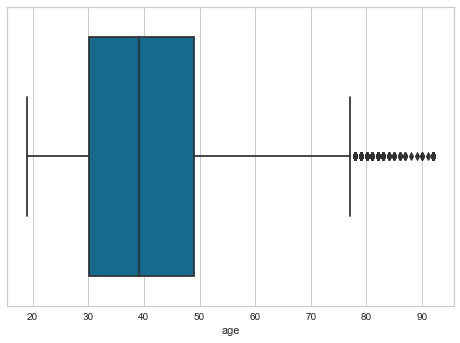

In [541]:
### trying to remove the outliers on age##

sns.boxplot(x = 'age', data = mod_data)

In [542]:
### we will remove the outliers based on the box plot ###
mod_data = mod_data[mod_data['age'] <= 78]

<AxesSubplot:xlabel='capital_gain'>

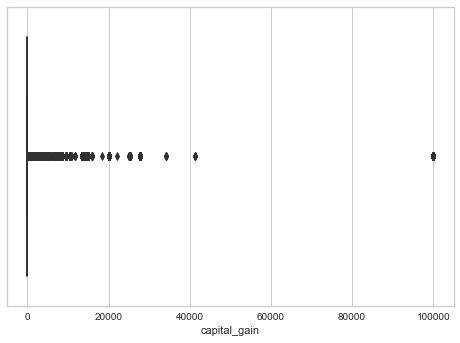

In [543]:
### trying to remove the outliers on capital gains ##

sns.boxplot(x = 'capital_gain', data = mod_data)

In [544]:
## removing outliers on capital gains ##
## we are being conservative in our approach as we don't want to remove too many points ##

mod_data = mod_data[mod_data['capital_gain'] <= 20000]

<AxesSubplot:xlabel='capital_loss'>

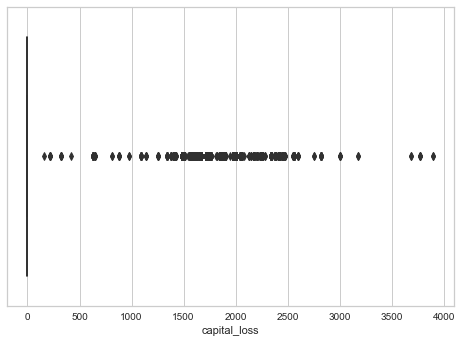

In [545]:
### trying to remove the outliers on capital loss ##

sns.boxplot(x = 'capital_loss', data = mod_data)

In [546]:
## removing outliers on capital loss ##
## we are being conservative in our approach as we don't want to remove too many points ##

mod_data = mod_data[mod_data['capital_loss'] <= 200]

<AxesSubplot:xlabel='hours_per_week'>

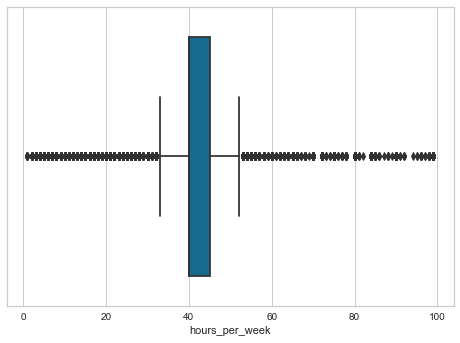

In [547]:
### trying to remove the outliers on capital loss ##

sns.boxplot(x = 'hours_per_week', data = mod_data)

In [548]:
## removing outliers on hours per week ##
## we are being conservative in our approach as we don't want to remove too many points ##

mod_data = mod_data[mod_data['hours_per_week'] >= 20]
mod_data = mod_data[mod_data['hours_per_week'] <= 80]

<AxesSubplot:xlabel='domain', ylabel='Count'>

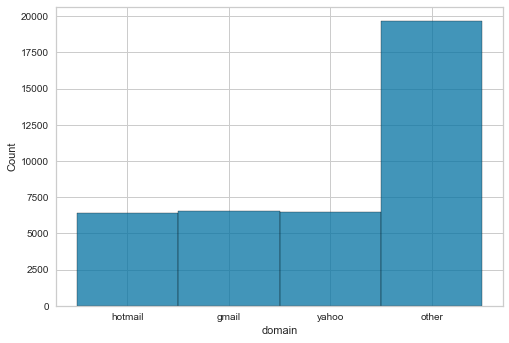

In [549]:
### trying to remove the outliers on capital loss ##

sns.histplot(x = 'domain', data = mod_data)

Most of the users applying for the card has a personal domain not belonging 
to one of the giants.

<AxesSubplot:xlabel='education_num', ylabel='Count'>

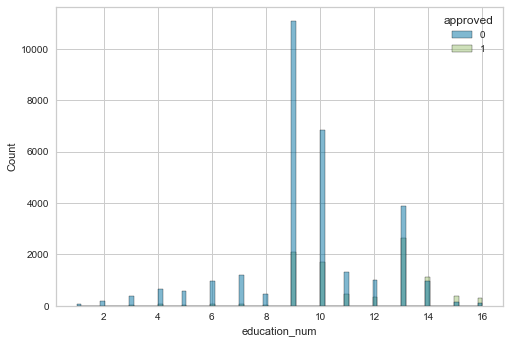

In [550]:
### trying to remove the outliers on capital loss ##

sns.histplot(x = 'education_num', data = mod_data, hue = "approved")

We can clearly see from the above plot that as the education num increases, the percentage of 
users getting approved is also increasing.

FixedFormatter should only be used together with FixedLocator


[Text(0, 0, ' Some-college'),
 Text(1, 0, ' HS-grad'),
 Text(2, 0, ' Masters'),
 Text(3, 0, ' 12th'),
 Text(4, 0, ' Bachelors'),
 Text(5, 0, ' Assoc-voc'),
 Text(6, 0, ' Assoc-acdm'),
 Text(7, 0, ' 9th'),
 Text(8, 0, ' 7th-8th'),
 Text(9, 0, ' 10th'),
 Text(10, 0, ' Prof-school'),
 Text(11, 0, ' 5th-6th'),
 Text(12, 0, ' 11th'),
 Text(13, 0, ' 1st-4th'),
 Text(14, 0, ' Doctorate'),
 Text(15, 0, ' Preschool')]

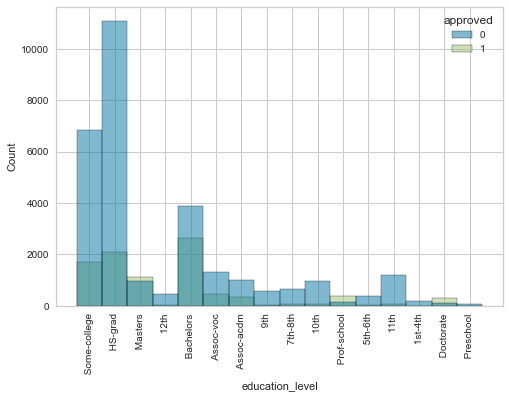

In [551]:
### trying to remove the outliers on capital loss ##

ax = sns.histplot(x = 'education_level', data = mod_data, hue = "approved")
ax.set_xticklabels(mod_data['education_level'].unique(),rotation = 90)

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


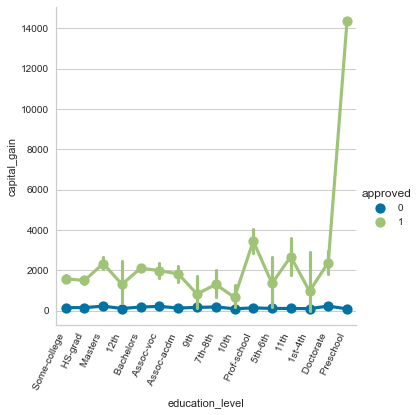

In [552]:
### capital gain vs education level ###

ax = sns.factorplot(y='capital_gain', x='education_level', hue='approved', data=mod_data, kind='point')
ax.set_xticklabels(label = None, rotation=65, horizontalalignment='right')


It is clear from the above plot that as the education level increases, the average capital gain is increasing.

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


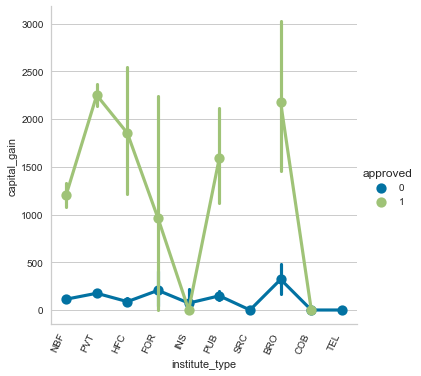

In [553]:
### capital gain vs education level

ax = sns.factorplot(y='capital_gain', x='institute_type', hue='approved', data=mod_data, kind='point')
ax.set_xticklabels(label = None, rotation=65, horizontalalignment='right')

#### feature scaling ###

We will try to scale all the features so that it doesn't affect the error function that we need to use.

In [554]:
mod_original = mod_data.copy(deep = True)

In [555]:
mod_data['age'] = (mod_data['age']-mod_data['age'].mean())/mod_data['age'].std()
mod_data['capital_gain'] = (mod_data['capital_gain']-mod_data['capital_gain'].mean())/mod_data['capital_gain'].std()
mod_data['capital_loss'] = (mod_data['capital_loss']-mod_data['capital_loss'].mean())/mod_data['capital_loss'].std()
mod_data['hours_per_week'] = (mod_data['hours_per_week']-mod_data['hours_per_week'].mean())/mod_data['hours_per_week'].std()

In [556]:
mod_data['gender'] = list(1 if i == "Male" else 0 for i in list(mod_data['gender']))

In [557]:
### making a copy of the data to be used later in logistic regression ###

dupl_mod_data = mod_data.copy(deep=True)

In [558]:
#### feature importance ####

A lot of ML models are hard to interpret and it is difficult to gauge the importance of each parameter in the model. 
To make the process of interpretation much easier, we will use a game theory library called Shapley Value Explanations. SHAP is used to provide a marginal importance numberto each paramter based on their importance. I am
using the same model in my research to isolate important features. 

In [559]:
### calculating SHAP values ###

In [560]:
# creating dummy variables for all the string variables so that they can be used in evaluating SHAP values ##
workclass = pd.get_dummies(mod_data['workclass'], drop_first = True)
education_level = pd.get_dummies(mod_data['education_level'], drop_first = True)
marital_status = pd.get_dummies(mod_data['marital_status'], drop_first = True)
occupation = pd.get_dummies(mod_data['occupation'], drop_first = True)
relationship = pd.get_dummies(mod_data['relationship'], drop_first = True)
inquiry_purpose_code = pd.get_dummies(mod_data['inquiry_purpose_code'], drop_first = True)
institute_type = pd.get_dummies(mod_data['institute_type'], drop_first = True)
account_type = pd.get_dummies(mod_data['account_type'], drop_first = True)
asset_code = pd.get_dummies(mod_data['asset_code'], drop_first = True)
portfolio_type = pd.get_dummies(mod_data['portfolio_type'], drop_first = True)
domain = pd.get_dummies(mod_data['domain'], drop_first = True)

mod_data.drop(['workclass', 'education_level', 'marital_status', 'occupation', 'relationship','inquiry_purpose_code', 'institute_type', 'account_type', 'asset_code', 'portfolio_type', 'domain'], axis = 1, inplace = True)

mod_data = pd.concat([mod_data, workclass, education_level, occupation,relationship, inquiry_purpose_code, institute_type,
                account_type, asset_code, portfolio_type, domain], axis = 1)

In [561]:
part_data = mod_data

X = mod_data.loc[:, mod_data.columns !=  'approved']
X = X.loc[:, X.columns !=  'user_id']
X = X.loc[:, X.columns !=  'email']
X = X.loc[:, X.columns !=  'zipcode']
X = X.loc[:, X.columns !=  'date_of_birth']
X = X.loc[:, X.columns !=  'address']
Y = mod_data['approved']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

masker = shap.maskers.Independent(data = X_test)


model = LogisticRegression(random_state=1, max_iter=1000).fit(X_train, y_train.values.ravel())

explainer = shap.LinearExplainer(model, masker=masker)
shap_values = explainer(X_test)

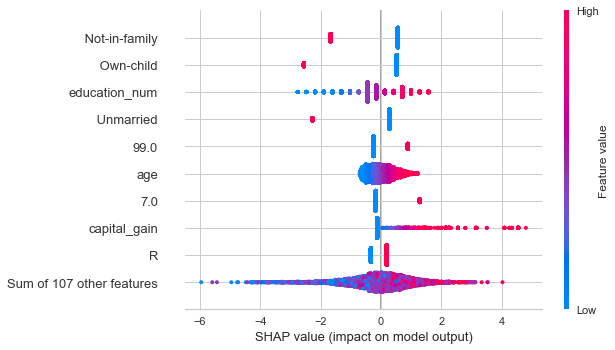

In [562]:
shap.plots.beeswarm(shap_values)

From the above chart it is clear that relationships, education_num, marital_status, age, capital gains 
play the most major role in deciding what features to include. We will go from there and add variables
in sort of forward step wise regression, i.e. once a variable has been added to the model, it will not be removed. 

In [563]:
### running the first logistic regression model ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))


Optimization terminated successfully.
         Current function value: 0.351092
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39086
Method:                           MLE   Df Model:                            8
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3605
Time:                        21:54:25   Log-Likelihood:                -13726.
converged:                       True   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        approved=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -4.1915      0.076    

In [564]:

### adding one more independent variable to the above model ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship) + C(education_level)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))

         Current function value: 0.350242
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39071
Method:                           MLE   Df Model:                           23
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3621
Time:                        21:54:26   Log-Likelihood:                -13693.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.8811        nan        nan        nan         nan   

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


All predictions of education_level are none and hence, it is of no use to us, we will remove it. 

In [565]:
## adding another variable ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship)  + C(occupation)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))

Optimization terminated successfully.
         Current function value: 0.340046
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39073
Method:                           MLE   Df Model:                           21
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3807
Time:                        21:54:26   Log-Likelihood:                -13294.
converged:                       True   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.5252      0.103 

AIC decreases again and there is also an increase in adjusted R2. 

In [566]:
## adding another variable ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship) + C(occupation) + C(institute_type)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))


         Current function value: 0.337611
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39064
Method:                           MLE   Df Model:                           30
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3851
Time:                        21:54:27   Log-Likelihood:                -13199.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.8662      0.200    -14.352      0.000      -3.258   

Maximum Likelihood optimization failed to converge. Check mle_retvals


AIC decreases but -log likelihood increases and but since the drop in AIC is very significant.

In [567]:
## adding another variable ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship)  + C(occupation) + C(institute_type) + C(domain)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))



         Current function value: 0.337530
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39061
Method:                           MLE   Df Model:                           33
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3852
Time:                        21:54:28   Log-Likelihood:                -13196.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.8447      0.203    -14.027      0.000      -3.242   

Maximum Likelihood optimization failed to converge. Check mle_retvals


No such change in AIC value and hence, we will not include domain.

In [568]:
## adding another variable ###

formula = 'approved ~ age + education_num + capital_gain + C(relationship)  + C(occupation) + C(institute_type) + C(portfolio_type)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))


         Current function value: 0.337607
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39090
Model:                        MNLogit   Df Residuals:                    39056
Method:                           MLE   Df Model:                           33
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3851
Time:                        21:54:29   Log-Likelihood:                -13197.
converged:                      False   LL-Null:                       -21462.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -5.0495      1.130     -4.469      0.000      -7.264   

Maximum Likelihood optimization failed to converge. Check mle_retvals


AIC value increases and hence, we will not include portfolio type in our data.

In [569]:
## adding another variable ###

formula = 'approved ~ age + education_num + capital_gain + C(inquiry_purpose_code) + C(relationship)  + C(occupation) + C(institute_type)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))

         Current function value: 0.327300
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39047
Method:                           MLE   Df Model:                           47
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.4039
Time:                        21:54:31   Log-Likelihood:                -12796.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.4230      0.312    -14.158      0.000      -5.035   

Maximum Likelihood optimization failed to converge. Check mle_retvals


In [570]:
formula = 'approved ~ age + education_num + hours_per_week + capital_gain + C(inquiry_purpose_code) + C(relationship)  + C(occupation) + C(institute_type)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))

Optimization terminated successfully.
         Current function value: nan
         Iterations 15
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39046
Method:                           MLE   Df Model:                           48
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                     nan
Time:                        21:54:32   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                       nan
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                  nan        nan     

overflow encountered in exp
invalid value encountered in true_divide


Hours per week is not giving meaningful results and hence, we will not include that in our model. 

In [571]:
formula = 'approved ~ age + education_num + capital_gain + capital_loss + C(inquiry_purpose_code) + C(relationship)  + C(occupation) + C(institute_type)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))


         Current function value: 0.327300
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39046
Method:                           MLE   Df Model:                           48
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.4039
Time:                        21:54:33   Log-Likelihood:                -12796.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         approved=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.4235     13.735     -0.322      0.747     -31.343   

Maximum Likelihood optimization failed to converge. Check mle_retvals


AIC increases for capital loss and hence won't be included in our model. 

In [572]:
formula = 'approved ~ age + education_num + capital_gain + C(inquiry_purpose_code) + C(relationship)  + C(occupation) + C(institute_type) + C(marital_status)'
fit = smf.mnlogit(formula=formula, data=dupl_mod_data).fit()
print(fit.summary())

print("AIC =", str(fit.aic))


         Current function value: 0.325658
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               approved   No. Observations:                39095
Model:                        MNLogit   Df Residuals:                    39041
Method:                           MLE   Df Model:                           53
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                  0.4069
Time:                        21:54:34   Log-Likelihood:                -12732.
converged:                      False   LL-Null:                       -21465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 approved=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -6.7794      0.394    -17.200  

Maximum Likelihood optimization failed to converge. Check mle_retvals


Marital status is leading to an decrease in AIC and hence, we will include that in our model. 

 ### Now, that we have our logistic regression model, we will move onto checking if all the assumptions are satisfied.

In [573]:
### chosen model ###
## calculating vif for quantitative variables ##


y, X = dmatrices('approved ~ age + education_num + capital_gain + capital_loss', data=dupl_mod_data, return_type='dataframe')

#calculate VIF for each explanatory variable

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,17.469079,Intercept
1,1.012956,age
2,1.022198,education_num
3,1.034530,capital_gain
4,1.000083,capital_loss


Since all the vif values are around 1, we can safely assume that there is no multicolinearity in the dataset among quantitative variables. 

# Business Problem #

I think, since ABC is a mobile only bank, their business relies on their credit card customers not defaulting and hence, I believe from the data set, true negative is more important than true positive or the overall accuracy. The higher we can have true negative, the higher are the chances that we will be able to catch an user and not approve their credit card.

In [574]:
## dividing the data 

z_columns = ['approved','age', 'education_num','capital_gain', 'relationship', 'occupation', 'institute_type', 'inquiry_purpose_code', 'marital_status']

part_data = dupl_mod_data[z_columns]

X = part_data.loc[:,part_data.columns != 'approved']
Y = part_data['approved']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [579]:
XY_train = pd.concat([X_train, y_train], axis=1, join='inner')

formula = 'approved ~ age + education_num + capital_gain + C(inquiry_purpose_code) + C(relationship)  + C(occupation) + C(institute_type) + C(marital_status)'

### this cell will not run due to presence of perfect colinearity in the model and hence, the solver is not able 
### to invert the matrix.

# fit = smf.mnlogit(formula=formula, data=XY_train).fit()
# fit.summary()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'TPR')

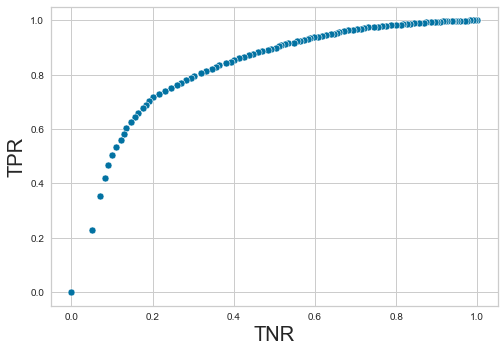

In [580]:
### using the validation set to find the optimized threshold value ####

true_negative = []
true_positive = []
threshold = []
expected = list(y_val)
predict = list(fit.predict(X_val)[1])

for i in list(np.linspace(0, 1, 100)):
    predicted = list(1 if j > i else 0 for j in predict)
    
    
    cm = confusion_matrix(expected, predicted)


    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    #print(TP, FN, FP, TN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    TPR = TP/(TP+FN)
    #print(TPR, TNR)
    
    true_negative.append(TNR)
    true_positive.append(TPR)
    
    threshold.append(i)
    

pt = sns.scatterplot(true_negative, true_positive[::-1])
pt.set_xlabel("TNR", fontsize = 20)
pt.set_ylabel("TPR", fontsize = 20)

At the threshold value of 0.2, we optimize our AUC curve above. We will now use this on our testing set. 

In [581]:
expected = list(y_test)
predict = list(fit.predict(X_test)[1])

predicted = list(1 if j > 0.2 else 0 for j in predict)
    
cm = confusion_matrix(expected, predicted)


TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
print(TP, FN, FP, TN)
    
    # Specificity or true negative rate
TNR = TN/(TN+FP)
TPR = TP/(TP+FN)
    #print(TPR, TNR)
    
print(TNR)
print(TPR)

4480 1458 227 1654
0.8793195108984583
0.754462782081509


From our out of sample testing, we are able to accurately predict 87.2 % of the users that we should decline. 
The accuracy may improve with more sophisticated models but interpretability decreases. 

Since, we have only taken small number of variables, we will not worry about FDR rate. But, in case it is required, 
we can always use the procedure of FDR correction but that will not affect the predictive power of the model, which is our main aim in this problem statement.

We would need a person's age, education num, capital gain, relationship status, occupation, institute type, marital status and inquiry purpose code to predict whether the user should be declined or not. 

A more sophisticated algorithm or inclusion of interaction terms might gives us better results but that would be 
unnecessary complication in the model since we have already have a high TNR. We will try one of the non-linear method XGB Classifier. Because there are so many variables, adding a penalty to be included in the model might gives us better results. 

In [582]:
dupl_2 = dupl_mod_data.copy(deep = True)


marital_status = pd.get_dummies(dupl_2['marital_status'], drop_first = True)
occupation = pd.get_dummies(dupl_2['occupation'], drop_first = True)
relationship = pd.get_dummies(dupl_2['relationship'], drop_first = True)
inquiry_purpose_code = pd.get_dummies(dupl_2['inquiry_purpose_code'], drop_first = True)
institute_type = pd.get_dummies(dupl_2['institute_type'], drop_first = True)

dupl_2 = dupl_2.loc[:,['age', 'education_num', 'capital_gain', 'approved']]

##mod_data.drop(['workclass', 'education_level', 'marital_status', 'occupation', 'relationship','inquiry_purpose_code', 'institute_type', 'account_type', 'asset_code', 'portfolio_type', 'domain'], axis = 1, inplace = True)

dupl_2 = pd.concat([dupl_2, occupation,relationship, inquiry_purpose_code, institute_type, marital_status], axis = 1)


X = dupl_2.loc[:,dupl_2.columns != 'approved']
Y = dupl_2['approved']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

[21:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'TPR')

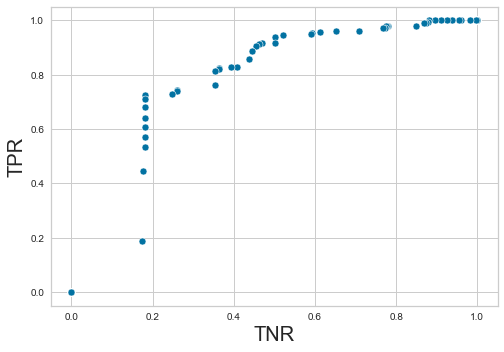

In [583]:
true_negative = []
true_positive = []
threshold = []
expected = list(y_val)

xgtrain = xgb.DMatrix(X_train, y_train)
xgval = xgb.DMatrix(X_val)

param = {'max_depth':7, 'silent':1}
bst = xgb.train(param, xgtrain, num_boost_round=2)
y_pred = bst.predict(xgval)

for i in list(np.linspace(0, 1, 100)):
    
    pred = [1. if y_cont > i  else 0. for y_cont in y_pred]
    y_true = y_val

    cm = confusion_matrix(y_true, pred)

    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]

    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    TPR = TP/(TP+FN)
    
    true_negative.append(TNR)
    true_positive.append(TPR)
    
    threshold.append(i)
    

pt = sns.scatterplot(true_negative, true_positive[::-1])
pt.set_xlabel("TNR", fontsize = 20)
pt.set_ylabel("TPR", fontsize = 20)

In [584]:
#### optimum value of threshold ####

### From the above ROC-AUC curve, we can say that the optimal value of threshold is around 0.20 and 0.3. Trying 0.25. 


xgtest = xgb.DMatrix(X_test)
y_pred = bst.predict(xgtest)

pred = [1. if y_cont > 0.3  else 0. for y_cont in y_pred]
y_true = y_test

cm = confusion_matrix(y_true, pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

    # Specificity or true negative rate
TNR = TN/(TN+FP)
TPR = TP/(TP+FN)

print("TPR: {}, and TNR: {}".format(TPR, TNR))

TPR: 0.615436129248284, and TNR: 0.9550379198266522


As we can see, the accuracy of the TNR has gone upto around 92%. We have to very careful with models of such high
accuracy as it can also be result of over-fitting but we are using an ensemble method along with OOS testing, telling 
us that the predictive power might just be this high and hence, we can use this model in prodcution.

### Calculation of credit limit #####

Since, capital gains is an important part of our model, we can use that to calculate the credit limit. As we can see that we are predicting with high accuracy the TNR rate. We also have a continuous probablity distribution fucntion, which we can use to calculate the credit limit that should be given. 

### credit limit = capital gains * f(probablity to be approved)

The above formula states how I propose the credit limit to be calculated. 

In [585]:
### defining a probablity distribution for all users ###

xgtest = xgb.DMatrix(X)
y_pred = bst.predict(xgtest)

Since we do not want the credit limit to be too high as compared to capital gains (lower the capital gains, larger the
chances of the user defaulting on payment. But, if we approve a person, there should be a minimum credit limit. Assuming that is equivalent to 800$. And, we are assuming the function to be an exponential function of the probability predicted.                                                                   

In [586]:
mean_v = mod_original['capital_gain'].mean()
std_dev = mod_original['capital_gain'].std()

In [587]:
## scaling back the capital gains to original values ##

capital_gain = list((i*std_dev)+mean_v for i in list(X['capital_gain']))

credit_limit = list(i*np.exp(j) + 800 for i, j in zip(capital_gain, y_pred))

In [592]:
mod_data

,user_id,gender,date_of_birth,education_num,capital_gain,capital_loss,hours_per_week,approved,address,email,...,999,2.0,4.0,19.0,I,M,R,hotmail,other,yahoo
1,519481f1-604d-48b6-aa47,0,1970-01-07,10,-0.250239,-0.005058,0.650839,0,"5022 Rebecca Haven Apt. 258\nThompsonfurt, CT ...",johnsontrevor@hotmail.com,...,0,0,0,0,0,0,1,1,0,0
2,f66fe2c6-53e3-46ce-8321,0,1973-01-06,9,-0.250239,-0.005058,0.860096,0,"8780 Brown Loaf Apt. 099\nNorth David, NJ 56510",morganemily@gmail.com,...,0,0,0,0,0,0,1,0,0,0
4,0e1977f3-3bef-4283-8d0a,0,1986-01-03,10,-0.250239,-0.005058,0.860096,0,"935 Burch Divide\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,...,0,0,0,0,1,0,0,0,0,0
6,27256e97-6bae-4ce6-9b80,0,2001-12-30,9,-0.250239,-0.005058,-1.860250,0,90598 Richardson Mountains Apt. 192\nJohnsonfu...,calvin66@hotmail.com,...,0,0,0,0,0,0,1,1,0,0
7,745b9022-fe0e-4d8e-8056,0,1996-12-31,10,-0.250239,-0.005058,0.860096,0,"28328 Bradley Views Suite 367\nSmithport, AK 5...",bwalker@yahoo.com,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44867,009569c0-1eff-467d-8e58,0,2051-01-12,9,6.660890,-0.005058,-0.186191,1,"692 Ann Viaduct\nSouth Kellyfort, MD 95995",rirwin@hotmail.com,...,0,0,0,0,0,0,1,1,0,0
44868,38609952-497d-49a0-836f,0,2046-01-13,10,6.660890,-0.005058,-0.186191,1,"70719 Charles Inlet\nKnightside, VA 44156",randerson@price.com,...,0,0,0,0,0,0,1,0,1,0
44869,209ffd58-c716-4302-b613,0,2046-01-13,9,6.660890,-0.005058,-0.186191,1,"51464 Roberts Trail\nLake Melissa, IN 41238",elizabethho@yahoo.com,...,0,0,0,0,0,0,1,0,0,1
44871,11f4ca41-5892-4cc4-84ba,0,2053-01-11,14,6.660890,-0.005058,3.161928,1,"2742 Bell Lake Apt. 219\nEast Ryanmouth, DE 81928",cooperdustin@gmail.com,...,0,0,0,0,0,0,1,0,0,0
